# Get run vs. sit FR scatter plot

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
run -im djd.main -- --dbname=dj_hmov -r

For remote access to work, make sure to first open an SSH tunnel with MySQL
port forwarding. Run the `djdtunnel` script in a separate terminal, with
optional `--user` argument if your local and remote user names differ.
Or, open the tunnel manually with:
  ssh -NL 3306:huxley.neuro.bzm:3306 -p 1021 USERNAME@tunnel.bio.lmu.de
Connecting execute@localhost:3306
Connected to database 'dj_hmov' as 'execute@10.153.172.3'
For remote file access to work, make sure to first mount the filesystem at tunnel.bio.lmu.de:1021 via SSHFS with `hux -r`


Function is similar to the `_get_rmi_fr()` function in hmov_unit.py but also returns the mean firing rate across all running and sitting periods.

In [28]:
def get_rmi(mseukey, stimcond='all'):
    """ Return running modulation index (RMI) of unit firing rates to the hollymov stimulus for
    specified stimulus condition, i.e. stimulus presentation, spontaneous condition
    (grey screen), or all.

    Parameters
    ----------
    key : dict
        Dictionary with mseu info.
    stimcond : str
        Stimulus condition, one of the following:
        * 'stim': only stimulus presentation
        * 'spont': spontaneous period (grey screen) before and after the stimulus blocks
        * 'all': the whole experiment including stim and spont

    Returns
    ----------
    rmi_fr : float
        Running modulation index = FR_run - FR_sit / (FR_run + FR_sit)
        based on firing rate.
    run_mean : float
        Mean firing rate across run periods.
    sit_mean : float
        Mean firing rate during sitting periods.
    """
    assert stimcond in ['all', 'stim', 'spont'], "stimcond should be one of the following: ['all', 'stim', 'spont']."
    
    # Fetch running activity
    run_t = (Run.Ball() & mseukey).fetch1('ball_t')
    run = (Run.Ball() & mseukey).fetch1('ball_speed')
    fs = (Run.Ball() & mseukey).fetch1('ball_sampfreq')
    
    # Fetch responses
    spkt = (Unit.Spikes()&mseukey).fetch1('spk_times')
    response, hist_edges = np.histogram(spkt, bins=run.shape[0])
    
    # Convert to spikes per second
    response_spks = response / (1 / fs)
    
    if stimcond is not 'all':
        tranges_trial, _ = (Stimulus().Trial() & mseukey).get_tranges()
        if stimcond == 'stim':
            # Only include tranges during movie stimulus presentation,i.e. those starting after
            # the first stim trial and ending before the end of the last stim trial
            cond_idxs = np.where(
                np.logical_and(run_t >= tranges_trial[0][0], run_t <= tranges_trial[-1][1]))
        if stimcond == 'spont':
            # Only include tranges during movie stimulus presentation,i.e. those starting after
            # the first stim trial and ending before the end of the last stim trial
            cond_idxs = np.where(
                np.logical_or(run_t <= tranges_trial[0][0], run_t >= tranges_trial[-1][1]))
        response_spks = response_spks[cond_idxs]
        run = run[cond_idxs]
    
    # Running: speed faster than 1.0 cm/s
    # Sitting: speed slower than 0.2 cm/s
    runi = np.where(run>1.0)[0]
    siti = np.where(run<0.25)[0]

    # Get responses corresponding to run state and sitting state
    resp_run = response_spks[runi]
    resp_sit = response_spks[siti]

    # Get mean firing rate
    run_mean = np.mean(resp_run)
    sit_mean = np.mean(resp_sit)

    # Get running modulation index
    rmi = (run_mean-sit_mean)/(run_mean+sit_mean)
    
    return rmi, run_mean, sit_mean

Get all populated keys:

In [19]:
keys = (SplineLNP()&{'spl_paramset':8}).fetch(dj.key) # units that pass the critical FR threshold

In [20]:
len(keys)

156

Get FR_sit and FR_run:

In [21]:
rmis = np.zeros((len(keys)))
frs_run = np.zeros((len(keys)))
frs_sit = np.zeros((len(keys)))
for i,key in enumerate(keys):
    rmi,frs_run[i],frs_sit[i] = get_rmi(key)
    rmis[i] = rmi

In [22]:
rmis.shape

(156,)

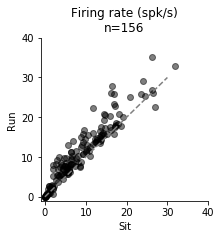

In [23]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(frs_sit, frs_run, color='k', alpha=0.5)
ax.plot([0,30], [0, 30], linestyle='--', color='gray')
ax.set_xlabel('Sit')
ax.set_ylabel('Run')
ax.set_ylim([-1, 40])
ax.set_xlim([-1, 40])
ax.set_title('Firing rate (spk/s)\nn={:d}'.format(len(keys)))
sns.despine()

## If stimcond='spont'

In [25]:
rmis = np.zeros((len(keys)))
frs_run = np.zeros((len(keys)))
frs_sit = np.zeros((len(keys)))
for i,key in enumerate(keys):
    rmi,frs_run[i],frs_sit[i] = get_rmi(key, stimcond='spont')
    rmis[i] = rmi

In [ ]:
rmis = np.zeros((len(keys)))
frs_run = np.zeros((len(keys)))
frs_sit = np.zeros((len(keys)))
for i,key in enumerate(keys):
    rmi,frs_run[i],frs_sit[i] = get_rmi(key)
    rmis[i] = rmi

In [30]:
rmis.shape

(156,)

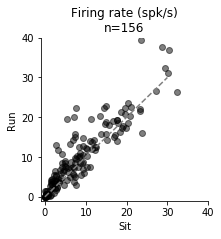

In [27]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(frs_sit, frs_run, color='k', alpha=0.5)
ax.plot([0,30], [0, 30], linestyle='--', color='gray')
ax.set_xlabel('Sit')
ax.set_ylabel('Run')
ax.set_ylim([-1, 40])
ax.set_xlim([-1, 40])
ax.set_title('Firing rate (spk/s)\nn={:d}'.format(len(keys)))
sns.despine()